In [1]:
import uproot
from tqdm import tqdm
import numpy as np

# txt files from
# https://doi.org/10.57760/sciencedb.16322

In [2]:
def read_root_file(filename, max_tags = 300):
    # Open the file and access the TTree
    with uproot.open(filename) as file:
        tree = file["sim"]

        # Load branches
        wf_i = tree["wf_i"].array(library="np")
        mom = tree["mom"].array(library="np")
        time = tree["time"].array(library="np")
        tag = tree["tag"].array(library="np")

        n_events = len(wf_i)

        # Preallocate output array
        result_dtype = np.dtype([
            ("wf_i", np.float32, (3000,)),
            ("mom", np.float32),
            ("tag_times", np.int32, (max_tags,)),
            ("tag_values", np.int32, (max_tags,))
        ])
        result = np.zeros(n_events, dtype=result_dtype)

        for i in range(n_events):
            result[i]["wf_i"] = wf_i[i]
            result[i]["mom"] = mom[i]

            tag_indices = np.where(tag[i] > 0)[0]
            n_tags = min(len(tag_indices), max_tags)

            # Fill the actual values, rest remains zero
            result[i]["tag_times"][:n_tags] = time[i][tag_indices[:n_tags]]
            result[i]["tag_values"][:n_tags] = tag[i][tag_indices[:n_tags]]

    return result

def process_multiple_files(file_list, output_file, max_tags = 300):
    all_data = []

    for filename in file_list:
        print(f"Processing: {filename}")
        data = read_root_file(filename, max_tags)
        all_data.append(data)

    combined_data = np.concatenate(all_data)
    np.savez_compressed(output_file, 
                        wf_i = combined_data['wf_i'],
                        mom = combined_data['mom'],
                        tag_times = combined_data['tag_times'],
                        tag_values = combined_data['tag_values'],)
    print(f"Saved combined data to {output_file}")

    return combined_data

In [3]:
import os
import numpy as np
import requests
from pathlib import Path
from tqdm import tqdm

from urllib.parse import urlparse, parse_qs

def get_filename_from_url(url):
    query = parse_qs(urlparse(url).query)
    return query.get('fileName', [os.path.basename(urlparse(url).path)])[0]

def download_file(url, output_dir):
    filename = get_filename_from_url(url)
    local_path = os.path.join(output_dir, filename)

    if os.path.exists(local_path):
        print(f"File already exists: {local_path}")
        return local_path

    try:
        with requests.get(url, stream=True, timeout=60) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('Content-Length', 0))
            block_size = 1024 * 1024  # 1 MB
            use_total = total_size > 0

            desc = filename[:40] + ("..." if len(filename) > 40 else "")
            t = tqdm(total=total_size if use_total else None,
                     unit='iB', unit_scale=True, desc=desc)

            with open(local_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=block_size):
                    if chunk:
                        f.write(chunk)
                        t.update(len(chunk))
            t.close()

        return local_path
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return None

def process_in_batches(url_file, output_dir, batch_size, max_tags):
    # Make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Read all URLs
    with open(url_file, 'r') as f:
        urls = [line.strip() for line in f if line.strip()]

    # Process in batches
    for i in range(0, len(urls), batch_size):
        batch_urls = urls[i:i+batch_size]
        local_files = []

        print(f"Processing batch {i // batch_size + 1}...")
        for url in batch_urls:
            local_path = download_file(url, output_dir)
            local_files.append(local_path)

        npz_name = os.path.join(output_dir, f"batch_{i // batch_size}.npz")
        data = process_multiple_files(local_files, npz_name, max_tags)

        # Clean up downloaded root files
        for fpath in local_files:
            os.remove(fpath)

        print(f"Saved {npz_name} and deleted temporary root files.\n")

    return data

In [ ]:
max_tags = 300

data = process_in_batches("./peakfind_train.txt", "kaon", batch_size=10, max_tags=300)

Processing batch 1...


signal_noise05_PFtrain_20.root: 100%|██████████| 403M/403M [00:31<00:00, 12.8MiB/s] 
signal_noise05_PFtrain_11.root: 100%|██████████| 403M/403M [00:32<00:00, 12.4MiB/s] 
signal_noise05_PFtrain_18.root:  43%|████▎     | 172M/403M [08:38<24:36, 156kiB/s]  

In [ ]:
process_in_batches("./peakfind_test.txt", "processed_data_test", batch_size=10, max_tags=300)

In [50]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

(10000, 3000)
(10000,)
(10000, 300)
(10000, 300)


In [29]:
#print(data['wf_i'][0])
#print(data['mom'][0])
#print(data['tag_times'][0])
print(data['tag_values'][0])
#print(data['tag_mask'][0])

[1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [30]:
import matplotlib.pyplot as plt

(0.0, 14.557700336538256)

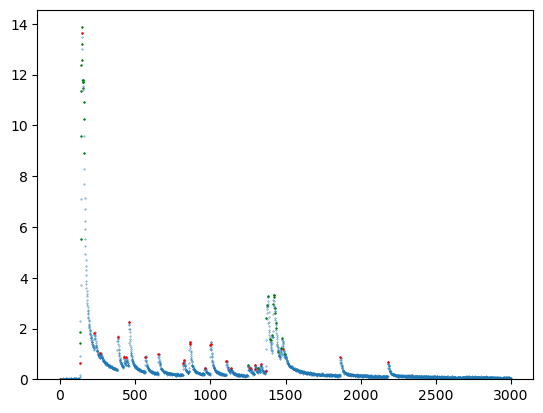

In [44]:
iev = 0
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=0.1);
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=0.6,color='r')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=0.4,color='g')
plt.ylim(0)

# Kaon Pion Loading

In [5]:
# get all urls and make new files for just the kaon urls and just the pion urls

file_path = 'all_file_urls.txt'
with open(file_path, 'r') as f:
        urls = [line.strip() for line in f if line.strip()]

kaon_urls = []
pion_urls = []

for url in urls:
    if 'kaon' in url:
        kaon_urls.append(url)

    if 'pion' in url:
        pion_urls.append(url)

In [6]:
with open('kaon_urls.txt', 'w') as file:
    for line in kaon_urls:
        file.write(line + '\n') 

with open('pion_urls.txt', 'w') as file:
    for line in pion_urls:
        file.write(line + '\n') 

In [7]:
process_in_batches("./kaon_urls.txt", "kaon", batch_size=10, max_tags=300)

Processing batch 1...


signal_K_12.5_57.root: 100%|██████████| 401M/401M [00:42<00:00, 9.51MiB/s] 
signal_K_20.0_35.root: 100%|██████████| 402M/402M [00:32<00:00, 12.3MiB/s] 
signal_K_17.5_60.root: 100%|██████████| 402M/402M [00:33<00:00, 12.2MiB/s] 
signal_K_12.5_55.root: 100%|██████████| 401M/401M [00:33<00:00, 12.1MiB/s] 
signal_K_12.5_50.root: 100%|██████████| 401M/401M [00:36<00:00, 11.0MiB/s] 
signal_K_20.0_32.root: 100%|██████████| 402M/402M [00:34<00:00, 11.8MiB/s] 
signal_K_10.0_18.root: 100%|██████████| 401M/401M [00:32<00:00, 12.3MiB/s] 
signal_K_10.0_10.root: 100%|██████████| 401M/401M [00:31<00:00, 12.5MiB/s] 
signal_K_5.0_5.root: 100%|██████████| 400M/400M [00:34<00:00, 11.7MiB/s] 
signal_K_17.5_61.root: 100%|██████████| 402M/402M [00:33<00:00, 11.8MiB/s] 


Processing: kaon/signal_K_12.5_57.root
Processing: kaon/signal_K_20.0_35.root
Processing: kaon/signal_K_17.5_60.root
Processing: kaon/signal_K_12.5_55.root
Processing: kaon/signal_K_12.5_50.root
Processing: kaon/signal_K_20.0_32.root
Processing: kaon/signal_K_10.0_18.root
Processing: kaon/signal_K_10.0_10.root
Processing: kaon/signal_K_5.0_5.root
Processing: kaon/signal_K_17.5_61.root
Saved combined data to kaon/batch_0.npz
Saved kaon/batch_0.npz and deleted temporary root files.

Processing batch 2...


signal_K_17.5_67.root: 100%|██████████| 402M/402M [00:33<00:00, 12.2MiB/s] 
signal_K_15.0_20.root: 100%|██████████| 402M/402M [00:34<00:00, 11.6MiB/s] 
signal_K_5.0_6.root: 100%|██████████| 400M/400M [00:34<00:00, 11.7MiB/s] 
signal_K_10.0_14.root: 100%|██████████| 401M/401M [00:33<00:00, 11.9MiB/s] 
signal_K_5.0_9.root: 100%|██████████| 400M/400M [00:35<00:00, 11.3MiB/s] 


File already exists: kaon/signal_K_15.0_29.root
File already exists: kaon/signal_K_7.5_42.root
File already exists: kaon/signal_K_10.0_13.root
File already exists: kaon/signal_K_15.0_23.root
File already exists: kaon/signal_K_5.0_2.root
Processing: kaon/signal_K_17.5_67.root
Processing: kaon/signal_K_15.0_20.root
Processing: kaon/signal_K_5.0_6.root
Processing: kaon/signal_K_10.0_14.root
Processing: kaon/signal_K_5.0_9.root
Processing: kaon/signal_K_15.0_29.root
Processing: kaon/signal_K_7.5_42.root
Processing: kaon/signal_K_10.0_13.root
Processing: kaon/signal_K_15.0_23.root
Processing: kaon/signal_K_5.0_2.root
Saved combined data to kaon/batch_1.npz
Saved kaon/batch_1.npz and deleted temporary root files.

Processing batch 3...


signal_K_10.0_17.root: 100%|██████████| 401M/401M [00:33<00:00, 11.9MiB/s] 
signal_K_15.0_24.root: 100%|██████████| 402M/402M [00:32<00:00, 12.2MiB/s] 
signal_K_17.5_65.root: 100%|██████████| 402M/402M [00:32<00:00, 12.5MiB/s] 
signal_K_5.0_8.root: 100%|██████████| 400M/400M [00:32<00:00, 12.5MiB/s] 
signal_K_12.5_56.root: 100%|██████████| 401M/401M [00:34<00:00, 11.8MiB/s] 
signal_K_7.5_45.root: 100%|██████████| 400M/400M [00:35<00:00, 11.3MiB/s] 
signal_K_17.5_68.root: 100%|██████████| 402M/402M [00:32<00:00, 12.4MiB/s] 
signal_K_7.5_44.root: 100%|██████████| 400M/400M [00:34<00:00, 11.5MiB/s] 
signal_K_15.0_28.root: 100%|██████████| 401M/401M [00:31<00:00, 12.6MiB/s] 
signal_K_20.0_37.root: 100%|██████████| 402M/402M [00:32<00:00, 12.4MiB/s] 


Processing: kaon/signal_K_10.0_17.root
Processing: kaon/signal_K_15.0_24.root
Processing: kaon/signal_K_17.5_65.root
Processing: kaon/signal_K_5.0_8.root
Processing: kaon/signal_K_12.5_56.root
Processing: kaon/signal_K_7.5_45.root
Processing: kaon/signal_K_17.5_68.root
Processing: kaon/signal_K_7.5_44.root
Processing: kaon/signal_K_15.0_28.root
Processing: kaon/signal_K_20.0_37.root
Saved combined data to kaon/batch_2.npz
Saved kaon/batch_2.npz and deleted temporary root files.

Processing batch 4...


signal_K_15.0_27.root: 100%|██████████| 402M/402M [00:34<00:00, 11.7MiB/s] 
signal_K_15.0_26.root: 100%|██████████| 402M/402M [00:35<00:00, 11.4MiB/s] 
signal_K_7.5_40.root: 100%|██████████| 400M/400M [00:33<00:00, 12.1MiB/s] 
signal_K_20.0_39.root: 100%|██████████| 402M/402M [00:35<00:00, 11.4MiB/s] 
signal_K_7.5_46.root: 100%|██████████| 400M/400M [00:31<00:00, 12.6MiB/s] 
signal_K_17.5_69.root: 100%|██████████| 402M/402M [00:34<00:00, 11.7MiB/s] 
signal_K_12.5_58.root: 100%|██████████| 401M/401M [00:33<00:00, 11.9MiB/s] 
signal_K_10.0_19.root: 100%|██████████| 401M/401M [00:33<00:00, 12.0MiB/s] 
signal_K_15.0_22.root: 100%|██████████| 402M/402M [00:35<00:00, 11.4MiB/s] 
signal_K_20.0_34.root: 100%|██████████| 402M/402M [00:32<00:00, 12.5MiB/s] 


Processing: kaon/signal_K_15.0_27.root
Processing: kaon/signal_K_15.0_26.root
Processing: kaon/signal_K_7.5_40.root
Processing: kaon/signal_K_20.0_39.root
Processing: kaon/signal_K_7.5_46.root
Processing: kaon/signal_K_17.5_69.root
Processing: kaon/signal_K_12.5_58.root
Processing: kaon/signal_K_10.0_19.root
Processing: kaon/signal_K_15.0_22.root
Processing: kaon/signal_K_20.0_34.root
Saved combined data to kaon/batch_3.npz
Saved kaon/batch_3.npz and deleted temporary root files.

Processing batch 5...


signal_K_10.0_16.root: 100%|██████████| 401M/401M [00:31<00:00, 12.5MiB/s] 
signal_K_17.5_63.root: 100%|██████████| 402M/402M [00:32<00:00, 12.4MiB/s] 
signal_K_20.0_33.root: 100%|██████████| 402M/402M [00:32<00:00, 12.5MiB/s] 
signal_K_17.5_66.root: 100%|██████████| 402M/402M [00:34<00:00, 11.7MiB/s] 
signal_K_12.5_54.root: 100%|██████████| 401M/401M [00:32<00:00, 12.4MiB/s] 
signal_K_10.0_11.root: 100%|██████████| 401M/401M [00:36<00:00, 11.0MiB/s] 
signal_K_20.0_38.root: 100%|██████████| 402M/402M [00:34<00:00, 11.8MiB/s] 
signal_K_20.0_30.root: 100%|██████████| 402M/402M [00:32<00:00, 12.5MiB/s] 
signal_K_5.0_1.root: 100%|██████████| 400M/400M [00:33<00:00, 12.0MiB/s] 
signal_K_5.0_7.root: 100%|██████████| 400M/400M [00:33<00:00, 12.1MiB/s] 


Processing: kaon/signal_K_10.0_16.root
Processing: kaon/signal_K_17.5_63.root
Processing: kaon/signal_K_20.0_33.root
Processing: kaon/signal_K_17.5_66.root
Processing: kaon/signal_K_12.5_54.root
Processing: kaon/signal_K_10.0_11.root
Processing: kaon/signal_K_20.0_38.root
Processing: kaon/signal_K_20.0_30.root
Processing: kaon/signal_K_5.0_1.root
Processing: kaon/signal_K_5.0_7.root
Saved combined data to kaon/batch_4.npz
Saved kaon/batch_4.npz and deleted temporary root files.

Processing batch 6...


signal_K_5.0_3.root: 100%|██████████| 400M/400M [00:32<00:00, 12.1MiB/s] 
signal_K_7.5_48.root: 100%|██████████| 400M/400M [00:32<00:00, 12.2MiB/s] 
signal_K_12.5_52.root: 100%|██████████| 401M/401M [00:31<00:00, 12.7MiB/s] 
signal_K_7.5_41.root: 100%|██████████| 400M/400M [00:32<00:00, 12.2MiB/s] 
signal_K_12.5_51.root: 100%|██████████| 401M/401M [00:32<00:00, 12.2MiB/s] 
signal_K_7.5_43.root: 100%|██████████| 400M/400M [00:33<00:00, 12.0MiB/s] 
signal_K_15.0_25.root: 100%|██████████| 401M/401M [00:32<00:00, 12.2MiB/s] 
signal_K_15.0_21.root: 100%|██████████| 402M/402M [00:31<00:00, 12.6MiB/s] 
signal_K_10.0_12.root: 100%|██████████| 401M/401M [00:33<00:00, 12.0MiB/s] 
signal_K_7.5_47.root: 100%|██████████| 400M/400M [00:32<00:00, 12.4MiB/s] 


Processing: kaon/signal_K_5.0_3.root
Processing: kaon/signal_K_7.5_48.root
Processing: kaon/signal_K_12.5_52.root
Processing: kaon/signal_K_7.5_41.root
Processing: kaon/signal_K_12.5_51.root
Processing: kaon/signal_K_7.5_43.root
Processing: kaon/signal_K_15.0_25.root
Processing: kaon/signal_K_15.0_21.root
Processing: kaon/signal_K_10.0_12.root
Processing: kaon/signal_K_7.5_47.root
Saved combined data to kaon/batch_5.npz
Saved kaon/batch_5.npz and deleted temporary root files.

Processing batch 7...


signal_K_12.5_53.root: 100%|██████████| 401M/401M [00:32<00:00, 12.3MiB/s] 
signal_K_5.0_4.root: 100%|██████████| 400M/400M [00:33<00:00, 12.1MiB/s] 
signal_K_7.5_49.root: 100%|██████████| 400M/400M [00:32<00:00, 12.3MiB/s] 
signal_K_10.0_15.root: 100%|██████████| 401M/401M [00:33<00:00, 11.9MiB/s] 
signal_K_12.5_59.root: 100%|██████████| 401M/401M [00:33<00:00, 12.1MiB/s] 
signal_K_17.5_64.root: 100%|██████████| 402M/402M [00:32<00:00, 12.3MiB/s] 
signal_K_20.0_31.root: 100%|██████████| 402M/402M [00:37<00:00, 10.8MiB/s] 
signal_K_5.0_0.root: 100%|██████████| 400M/400M [00:32<00:00, 12.4MiB/s] 
signal_K_20.0_36.root: 100%|██████████| 402M/402M [00:32<00:00, 12.2MiB/s] 
signal_K_17.5_62.root: 100%|██████████| 402M/402M [00:32<00:00, 12.3MiB/s] 


Processing: kaon/signal_K_12.5_53.root
Processing: kaon/signal_K_5.0_4.root
Processing: kaon/signal_K_7.5_49.root
Processing: kaon/signal_K_10.0_15.root
Processing: kaon/signal_K_12.5_59.root
Processing: kaon/signal_K_17.5_64.root
Processing: kaon/signal_K_20.0_31.root
Processing: kaon/signal_K_5.0_0.root
Processing: kaon/signal_K_20.0_36.root
Processing: kaon/signal_K_17.5_62.root
Saved combined data to kaon/batch_6.npz
Saved kaon/batch_6.npz and deleted temporary root files.



array([([ 1.42939975e-02,  3.39381769e-02, -1.44113749e-02, ...,  6.77389354e-02,  7.89171979e-02,  6.64613023e-02], 12.5, [ 126,  127,  128,  132,  142,  150,  151,  185,  187,  220,  224,  233,  249,  265,  274,  285,  310,  323,  387,  393,  402,  515,  533,  553,  582,  584,  585,  590,  591,  592,  594,  596,  598,  604,  605,  607,  609,  610,  611,  613,  614,  616,  617,  618,  622,  624,  625,  627,  628,  629,  631,  633,  635,  637,  639,  640,  641,  644,  646,  647,  649,  651,  654,  655,  656,  657,  660,  664,  673,  695,  754,  868,  869,  963,  964, 1064, 1065, 1108, 1223, 1383, 1439, 1497, 1513, 2252, 2350,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 

In [8]:
process_in_batches("./pion_urls.txt", "pion", batch_size=10, max_tags=300)

Processing batch 1...


signal_pi_7.5_44.root: 100%|██████████| 403M/403M [00:32<00:00, 12.3MiB/s] 
signal_pi_12.5_51.root: 100%|██████████| 404M/404M [00:33<00:00, 12.2MiB/s] 
signal_pi_5.0_1.root: 100%|██████████| 402M/402M [00:33<00:00, 12.1MiB/s] 
signal_pi_12.5_59.root: 100%|██████████| 403M/403M [00:33<00:00, 12.1MiB/s] 
signal_pi_5.0_6.root: 100%|██████████| 402M/402M [00:33<00:00, 12.2MiB/s] 
signal_pi_5.0_3.root: 100%|██████████| 402M/402M [00:33<00:00, 12.1MiB/s] 
signal_pi_17.5_69.root: 100%|██████████| 404M/404M [00:32<00:00, 12.3MiB/s] 
signal_pi_7.5_47.root: 100%|██████████| 403M/403M [00:32<00:00, 12.4MiB/s] 
signal_pi_17.5_65.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 
signal_pi_5.0_9.root: 100%|██████████| 402M/402M [00:32<00:00, 12.3MiB/s] 


Processing: pion/signal_pi_7.5_44.root
Processing: pion/signal_pi_12.5_51.root
Processing: pion/signal_pi_5.0_1.root
Processing: pion/signal_pi_12.5_59.root
Processing: pion/signal_pi_5.0_6.root
Processing: pion/signal_pi_5.0_3.root
Processing: pion/signal_pi_17.5_69.root
Processing: pion/signal_pi_7.5_47.root
Processing: pion/signal_pi_17.5_65.root
Processing: pion/signal_pi_5.0_9.root
Saved combined data to pion/batch_0.npz
Saved pion/batch_0.npz and deleted temporary root files.

Processing batch 2...


signal_pi_10.0_12.root: 100%|██████████| 403M/403M [00:32<00:00, 12.5MiB/s] 
signal_pi_12.5_55.root: 100%|██████████| 403M/403M [00:33<00:00, 12.0MiB/s] 
signal_pi_10.0_11.root: 100%|██████████| 403M/403M [00:32<00:00, 12.4MiB/s] 
signal_pi_17.5_62.root: 100%|██████████| 404M/404M [00:33<00:00, 12.2MiB/s] 
signal_pi_10.0_17.root: 100%|██████████| 403M/403M [00:32<00:00, 12.3MiB/s] 
signal_pi_10.0_19.root: 100%|██████████| 403M/403M [00:31<00:00, 12.7MiB/s] 
signal_pi_12.5_52.root: 100%|██████████| 403M/403M [00:33<00:00, 12.2MiB/s] 
signal_pi_10.0_15.root: 100%|██████████| 403M/403M [00:32<00:00, 12.3MiB/s] 
signal_pi_10.0_16.root: 100%|██████████| 403M/403M [00:31<00:00, 12.8MiB/s] 
signal_pi_20.0_39.root: 100%|██████████| 404M/404M [00:31<00:00, 12.8MiB/s] 


Processing: pion/signal_pi_10.0_12.root
Processing: pion/signal_pi_12.5_55.root
Processing: pion/signal_pi_10.0_11.root
Processing: pion/signal_pi_17.5_62.root
Processing: pion/signal_pi_10.0_17.root
Processing: pion/signal_pi_10.0_19.root
Processing: pion/signal_pi_12.5_52.root
Processing: pion/signal_pi_10.0_15.root
Processing: pion/signal_pi_10.0_16.root
Processing: pion/signal_pi_20.0_39.root
Saved combined data to pion/batch_1.npz
Saved pion/batch_1.npz and deleted temporary root files.

Processing batch 3...


signal_pi_12.5_58.root: 100%|██████████| 403M/403M [00:32<00:00, 12.4MiB/s] 
signal_pi_20.0_35.root: 100%|██████████| 404M/404M [00:31<00:00, 12.7MiB/s] 
signal_pi_12.5_50.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 
signal_pi_20.0_30.root: 100%|██████████| 404M/404M [00:33<00:00, 12.0MiB/s] 
signal_pi_10.0_10.root: 100%|██████████| 403M/403M [00:32<00:00, 12.2MiB/s] 
signal_pi_20.0_31.root: 100%|██████████| 404M/404M [00:32<00:00, 12.6MiB/s] 
signal_pi_5.0_7.root: 100%|██████████| 402M/402M [00:32<00:00, 12.4MiB/s] 
signal_pi_7.5_43.root: 100%|██████████| 403M/403M [00:32<00:00, 12.4MiB/s] 
signal_pi_15.0_25.root: 100%|██████████| 404M/404M [00:33<00:00, 12.2MiB/s] 
signal_pi_17.5_63.root: 100%|██████████| 404M/404M [00:33<00:00, 12.1MiB/s] 


Processing: pion/signal_pi_12.5_58.root
Processing: pion/signal_pi_20.0_35.root
Processing: pion/signal_pi_12.5_50.root
Processing: pion/signal_pi_20.0_30.root
Processing: pion/signal_pi_10.0_10.root
Processing: pion/signal_pi_20.0_31.root
Processing: pion/signal_pi_5.0_7.root
Processing: pion/signal_pi_7.5_43.root
Processing: pion/signal_pi_15.0_25.root
Processing: pion/signal_pi_17.5_63.root
Saved combined data to pion/batch_2.npz
Saved pion/batch_2.npz and deleted temporary root files.

Processing batch 4...


signal_pi_15.0_27.root: 100%|██████████| 404M/404M [00:33<00:00, 12.2MiB/s] 
signal_pi_20.0_37.root: 100%|██████████| 404M/404M [00:34<00:00, 11.7MiB/s] 
signal_pi_12.5_57.root: 100%|██████████| 403M/403M [00:32<00:00, 12.6MiB/s] 
signal_pi_10.0_18.root: 100%|██████████| 403M/403M [00:32<00:00, 12.5MiB/s] 
signal_pi_15.0_28.root: 100%|██████████| 404M/404M [00:32<00:00, 12.3MiB/s] 
signal_pi_7.5_49.root: 100%|██████████| 403M/403M [00:33<00:00, 12.0MiB/s] 
signal_pi_5.0_8.root: 100%|██████████| 402M/402M [00:31<00:00, 12.6MiB/s] 
signal_pi_15.0_22.root: 100%|██████████| 404M/404M [00:32<00:00, 12.3MiB/s] 
signal_pi_5.0_4.root: 100%|██████████| 402M/402M [00:31<00:00, 12.6MiB/s] 
signal_pi_5.0_2.root: 100%|██████████| 402M/402M [00:32<00:00, 12.4MiB/s] 


Processing: pion/signal_pi_15.0_27.root
Processing: pion/signal_pi_20.0_37.root
Processing: pion/signal_pi_12.5_57.root
Processing: pion/signal_pi_10.0_18.root
Processing: pion/signal_pi_15.0_28.root
Processing: pion/signal_pi_7.5_49.root
Processing: pion/signal_pi_5.0_8.root
Processing: pion/signal_pi_15.0_22.root
Processing: pion/signal_pi_5.0_4.root
Processing: pion/signal_pi_5.0_2.root
Saved combined data to pion/batch_3.npz
Saved pion/batch_3.npz and deleted temporary root files.

Processing batch 5...


signal_pi_7.5_46.root: 100%|██████████| 403M/403M [00:32<00:00, 12.2MiB/s] 
signal_pi_17.5_61.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 
signal_pi_20.0_36.root: 100%|██████████| 404M/404M [00:33<00:00, 12.0MiB/s] 
signal_pi_20.0_34.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 
signal_pi_15.0_29.root: 100%|██████████| 404M/404M [00:33<00:00, 12.2MiB/s] 
signal_pi_7.5_45.root: 100%|██████████| 403M/403M [00:32<00:00, 12.3MiB/s] 
signal_pi_12.5_54.root: 100%|██████████| 403M/403M [00:34<00:00, 11.6MiB/s] 
signal_pi_15.0_23.root: 100%|██████████| 404M/404M [00:33<00:00, 12.1MiB/s] 
signal_pi_12.5_53.root: 100%|██████████| 403M/403M [00:32<00:00, 12.4MiB/s] 
signal_pi_15.0_26.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 


Processing: pion/signal_pi_7.5_46.root
Processing: pion/signal_pi_17.5_61.root
Processing: pion/signal_pi_20.0_36.root
Processing: pion/signal_pi_20.0_34.root
Processing: pion/signal_pi_15.0_29.root
Processing: pion/signal_pi_7.5_45.root
Processing: pion/signal_pi_12.5_54.root
Processing: pion/signal_pi_15.0_23.root
Processing: pion/signal_pi_12.5_53.root
Processing: pion/signal_pi_15.0_26.root
Saved combined data to pion/batch_4.npz
Saved pion/batch_4.npz and deleted temporary root files.

Processing batch 6...


signal_pi_7.5_41.root: 100%|██████████| 403M/403M [00:31<00:00, 12.6MiB/s] 
signal_pi_7.5_42.root: 100%|██████████| 403M/403M [00:31<00:00, 12.7MiB/s] 
signal_pi_15.0_20.root: 100%|██████████| 404M/404M [00:33<00:00, 11.9MiB/s] 
signal_pi_17.5_64.root: 100%|██████████| 404M/404M [00:32<00:00, 12.2MiB/s] 
signal_pi_10.0_13.root: 100%|██████████| 403M/403M [00:32<00:00, 12.5MiB/s] 
signal_pi_10.0_14.root: 100%|██████████| 403M/403M [00:32<00:00, 12.5MiB/s] 
signal_pi_20.0_38.root: 100%|██████████| 404M/404M [00:32<00:00, 12.6MiB/s] 
signal_pi_20.0_33.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 
signal_pi_17.5_60.root: 100%|██████████| 404M/404M [00:32<00:00, 12.5MiB/s] 
signal_pi_12.5_56.root: 100%|██████████| 404M/404M [00:31<00:00, 12.6MiB/s] 


Processing: pion/signal_pi_7.5_41.root
Processing: pion/signal_pi_7.5_42.root
Processing: pion/signal_pi_15.0_20.root
Processing: pion/signal_pi_17.5_64.root
Processing: pion/signal_pi_10.0_13.root
Processing: pion/signal_pi_10.0_14.root
Processing: pion/signal_pi_20.0_38.root
Processing: pion/signal_pi_20.0_33.root
Processing: pion/signal_pi_17.5_60.root
Processing: pion/signal_pi_12.5_56.root
Saved combined data to pion/batch_5.npz
Saved pion/batch_5.npz and deleted temporary root files.

Processing batch 7...


signal_pi_17.5_66.root: 100%|██████████| 404M/404M [00:34<00:00, 11.6MiB/s] 
signal_pi_17.5_68.root: 100%|██████████| 404M/404M [00:33<00:00, 11.9MiB/s] 
signal_pi_15.0_21.root: 100%|██████████| 404M/404M [00:33<00:00, 12.1MiB/s] 
signal_pi_7.5_48.root: 100%|██████████| 403M/403M [00:32<00:00, 12.3MiB/s] 
signal_pi_15.0_24.root: 100%|██████████| 404M/404M [00:34<00:00, 11.8MiB/s] 
signal_pi_20.0_32.root: 100%|██████████| 404M/404M [00:32<00:00, 12.4MiB/s] 
signal_pi_5.0_0.root: 100%|██████████| 402M/402M [00:33<00:00, 11.9MiB/s] 
signal_pi_7.5_40.root: 100%|██████████| 403M/403M [00:32<00:00, 12.3MiB/s] 
signal_pi_17.5_67.root: 100%|██████████| 404M/404M [00:33<00:00, 12.1MiB/s] 
signal_pi_5.0_5.root: 100%|██████████| 402M/402M [00:35<00:00, 11.3MiB/s] 


Processing: pion/signal_pi_17.5_66.root
Processing: pion/signal_pi_17.5_68.root
Processing: pion/signal_pi_15.0_21.root
Processing: pion/signal_pi_7.5_48.root
Processing: pion/signal_pi_15.0_24.root
Processing: pion/signal_pi_20.0_32.root
Processing: pion/signal_pi_5.0_0.root
Processing: pion/signal_pi_7.5_40.root
Processing: pion/signal_pi_17.5_67.root
Processing: pion/signal_pi_5.0_5.root
Saved combined data to pion/batch_6.npz
Saved pion/batch_6.npz and deleted temporary root files.



array([([-9.73399263e-03, -2.34573931e-02, -1.81217901e-02, ...,  8.82396754e-03,  1.04976371e-02,  2.26219390e-02], 17.5, [ 126,  132,  148,  169,  197,  203,  259,  336,  440,  572,  603,  659,  685,  711,  875,  902,  939,  991, 1041, 1143, 1186, 1258, 1296, 1335, 1379, 1388, 1418, 1481, 1492, 1674, 2600,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 

In [12]:
import tensorflow as tf
tf.__version__

'2.14.0'